# EY EXTRA SEATS and CABIN UPGRADE conversion

In [32]:
!pip install ipython-sql

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [33]:
#!pip install -U numpy

In [34]:
#!python --version

In [35]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [36]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [37]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = '../../redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()




The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [38]:
query="""
SELECT * FROM ml_prep.gauthier_offer_load_all_wy_2019_2020_dataset ;
"""
df = pd.read_sql_query(query, con)
df.head(3)


event_time                          request_id  partner_id  \
0  2019-06-28T10:45:18Z  syQ6bpOMO5wMMETnDm5HsTM9WNwzOWOs4S         687   
1  2019-06-28T10:45:18Z  syQ6bpOMO5wMMETnDm5HsTM9WNwzOWOs4S         687   
2  2019-06-28T10:45:18Z  syQ6bpOMO5wMMETnDm5HsTM9WNwzOWOs4S         687   

  origin destination  flight_number departure_date departure_time from_cabin  \
0    MCT         KWI            647     2019-07-01          18:55    ECONOMY   
1    MCT         BKK            811     2019-08-09          02:20    ECONOMY   
2    KWI         MCT            648     2019-08-08          21:05    ECONOMY   

  upgrade_type  ... last_email_opened_time  email_opened_count  \
0     BUSINESS  ...    2019-06-29 06:03:43                  52   
1     BUSINESS  ...    2019-06-29 06:03:43                  52   
2     BUSINESS  ...    2019-06-29 06:03:43                  52   

  first_email_clicked_time last_email_clicked_time email_clicked_count  \
0      2019-06-27 07:42:51     2019-06-28 01:16:35                   8   
1      2019-06-27 07:42:51     2019-06-28 01:16:35                   8   
2      2019-06-27 07:42:51     2019-06-28 01:16:35                   8   

   offer_amount_usd  offer_amount_total_usd offer_quantity offer_customer_id  \
0               NaN                     NaN            NaN               NaN   
1               NaN                     NaN            NaN               NaN   
2               NaN                     NaN            NaN               NaN   

  offer_type  
0     NO_BID  
1     NO_BID  
2     NO_BID  

[3 rows x 50 columns]

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653971 entries, 0 to 653970
Data columns (total 50 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   event_time                          653971 non-null  object        
 1   request_id                          653971 non-null  object        
 2   partner_id                          653971 non-null  int64         
 3   origin                              653971 non-null  object        
 4   destination                         653971 non-null  object        
 5   flight_number                       653971 non-null  int64         
 6   departure_date                      653971 non-null  object        
 7   departure_time                      653971 non-null  object        
 8   from_cabin                          653971 non-null  object        
 9   upgrade_type                        653971 non-null  object        
 10  first_of

# Feature Engineering

In [43]:
#drop non relevant fields
df = df.drop(['distance_unit', 'request_id', 'slider_min','slider_max', 'slider_step', 'pnr', 
         'instant_upgrade_eligibility_reason', 'eligibility_reason', 'instant_upgrade_eligibility','slider_step'
        ], axis=1)



In [44]:
# compute some time-related features
# this takes some time
df['departure_hour'] = pd.to_datetime(df['departure_time']).apply(lambda x: x.hour)
df['departure_day_of_week']= pd.to_datetime(df['departure_date']).apply(lambda x: x.dayofweek)
df['departure_month']= pd.to_datetime(df['departure_date']).apply(lambda x: x.month)
df['event_day_of_week']= pd.to_datetime(df['event_time']).apply(lambda x: x.dayofweek)
df['event_hour']= pd.to_datetime(df['event_time']).apply(lambda x: x.hour)
df['event_month']= pd.to_datetime(df['event_time']).apply(lambda x: x.month)
df['event_year']= pd.to_datetime(df['event_time']).apply(lambda x: x.year)
df['origin_destination'] = df['origin']+ df['destination']
df["days_before_departure"] =(pd.to_datetime(df["departure_date"])-pd.to_datetime(df["event_time"]).dt.tz_localize(None)).apply(lambda x: x.days)
df["days_since_first_offer_load"] = (pd.to_datetime(df["event_time"]) - pd.to_datetime(df["first_offer_load_time"])).apply(lambda x: x.days)
df["first_offer_load_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_offer_load_time"]).dt.tz_localize(None)).apply(lambda x: x.days)

df["first_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_sent_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_sent"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_opened_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_opened"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["first_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["last_email_clicked_days_before_departure"] = (pd.to_datetime(df["departure_date"]) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_first_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_since_last_email_clicked"] = (pd.to_datetime(df["event_time"]).dt.tz_localize(None) - pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)

df["days_between_first_last_email_sent"] = (pd.to_datetime(df["last_email_sent_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_sent_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_opened"] = (pd.to_datetime(df["last_email_opened_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_opened_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)
df["days_between_first_last_email_clicked"] = (pd.to_datetime(df["last_email_clicked_time"]).dt.tz_localize(None) - pd.to_datetime(df["first_email_clicked_time"]).dt.tz_localize(None)).apply(lambda x: x.days).fillna(0).astype(int)



In [45]:
df["slider_min_usd"] = df["slider_min_usd"].fillna(0)
df["slider_max_usd"] = df["slider_max_usd"].fillna(0)
df["slider_start_usd"] = df["slider_start_usd"].fillna(0)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653971 entries, 0 to 653970
Data columns (total 67 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   event_time                                 653971 non-null  object        
 1   partner_id                                 653971 non-null  int64         
 2   origin                                     653971 non-null  object        
 3   destination                                653971 non-null  object        
 4   flight_number                              653971 non-null  int64         
 5   departure_date                             653971 non-null  object        
 6   departure_time                             653971 non-null  object        
 7   from_cabin                                 653971 non-null  object        
 8   upgrade_type                               653971 non-null  object        
 9   firs

# Feature Encoding

In [47]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [48]:
# label-encode categories
df= label_encode_categorical(df,['origin','channel_source','destination','origin_destination','language','point_of_sale','equipment'])

label encoding origin ...
label encoding channel_source ...
label encoding destination ...
label encoding origin_destination ...
label encoding language ...
label encoding point_of_sale ...
label encoding equipment ...


# Label encode

In [49]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['offer_type'])
df['offer_type_encoded'] = label_encoder.transform(df['offer_type'])

In [50]:
df.head(3)

event_time  partner_id origin destination  flight_number  \
0  2019-06-28T10:45:18Z         687    MCT         KWI            647   
1  2019-06-28T10:45:18Z         687    MCT         BKK            811   
2  2019-06-28T10:45:18Z         687    KWI         MCT            648   

  departure_date departure_time from_cabin upgrade_type first_offer_load_time  \
0     2019-07-01          18:55    ECONOMY     BUSINESS  2019-06-27T07:42:58Z   
1     2019-08-09          02:20    ECONOMY     BUSINESS  2019-06-27T07:42:58Z   
2     2019-08-08          21:05    ECONOMY     BUSINESS  2019-06-27T07:42:58Z   

   ...  days_between_first_last_email_opened  \
0  ...                                     4   
1  ...                                     4   
2  ...                                     4   

  days_between_first_last_email_clicked origin_encoded  \
0                                     0             41   
1                                     0             41   
2                                     0             35   

   channel_source_encoded  destination_encoded origin_destination_encoded  \
0                       0                   35                         78   
1                       0                    4                         47   
2                       0                   41                         37   

  language_encoded point_of_sale_encoded equipment_encoded  offer_type_encoded  
0                1                     7                 5                   1  
1                1                     7                 8                   1  
2                1                     7                 5                   1  

[3 rows x 75 columns]

In [51]:
columns_for_training= [
                       # departure time
                       'departure_hour',
                       'departure_day_of_week',
                       'departure_month',
                       # event time
                       'event_hour',
                       'event_day_of_week',
                       'event_month',
                       'event_year',
                       'days_before_departure',
                       # route
                       'origin_encoded', 
                       'destination_encoded',
                       'origin_destination_encoded',
                       'duration', 
                       'distance', 
                       # the rest
                       'channel_source_encoded',
                       'language_encoded',
                       'pax',
                       'point_of_sale_encoded',
                       'equipment_encoded',
                       # slider
                       'slider_max_usd',        
                       'slider_min_usd',        
                       'slider_start_usd',  
                       # previous offer loads
                        'offer_load_count',
                        'days_since_first_offer_load',
                        'first_offer_load_days_before_departure',
                       # email 
                        'first_email_sent_days_before_departure',
                        'last_email_sent_days_before_departure',
                        'days_since_first_email_sent',
                        'days_since_last_email_sent',
                        'first_email_opened_days_before_departure',
                        'last_email_opened_days_before_departure',
                        'days_since_first_email_opened',
                        'days_since_last_email_opened',
                        'first_email_clicked_days_before_departure',
                        'last_email_clicked_days_before_departure',
                        'days_since_first_email_clicked',
                        'days_since_last_email_clicked',
                        'days_between_first_last_email_sent',
                        'days_between_first_last_email_opened',
                        'days_between_first_last_email_clicked',
                        'email_sent_count',
                        'email_opened_count',
                        'email_clicked_count',
                       # target
                        'offer_type_encoded',
                      ]

df = df[columns_for_training]

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653971 entries, 0 to 653970
Data columns (total 43 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   departure_hour                             653971 non-null  int64  
 1   departure_day_of_week                      653971 non-null  int64  
 2   departure_month                            653971 non-null  int64  
 3   event_hour                                 653971 non-null  int64  
 4   event_day_of_week                          653971 non-null  int64  
 5   event_month                                653971 non-null  int64  
 6   event_year                                 653971 non-null  int64  
 7   days_before_departure                      653971 non-null  int64  
 8   origin_encoded                             653971 non-null  int64  
 9   destination_encoded                        653971 non-null  int64  
 10  origin_d

In [53]:
df.head(4)

departure_hour  departure_day_of_week  departure_month  event_hour  \
0              18                      0                7          10   
1               2                      4                8          10   
2              21                      3                8          10   
3              14                      0                7          10   

   event_day_of_week  event_month  event_year  days_before_departure  \
0                  4            6        2019                      2   
1                  4            6        2019                     41   
2                  4            6        2019                     40   
3                  4            6        2019                      2   

   origin_encoded  destination_encoded  ...  \
0              41                   35  ...   
1              41                    4  ...   
2              35                   41  ...   
3               4                   41  ...   

   last_email_clicked_days_before_departure  days_since_first_email_clicked  \
0                                         2                               1   
1                                        41                               1   
2                                        40                               1   
3                                         2                               1   

   days_since_last_email_clicked  days_between_first_last_email_sent  \
0                              0                                   2   
1                              0                                   2   
2                              0                                   2   
3                              0                                   2   

   days_between_first_last_email_opened  \
0                                     4   
1                                     4   
2                                     4   
3                                     4   

   days_between_first_last_email_clicked  email_sent_count  \
0                                      0                12   
1                                      0                12   
2                                      0                12   
3                                      0                12   

   email_opened_count  email_clicked_count  offer_type_encoded  
0                  52                    8                   1  
1                  52                    8                   1  
2                  52                    8                   1  
3                  52                    8                   1  

[4 rows x 43 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4827720438>]],
      dtype=object)

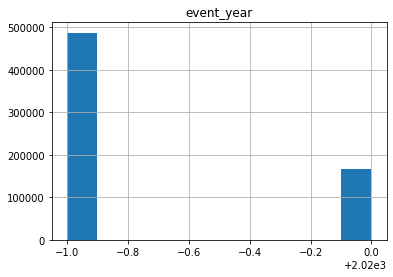

In [54]:
# we could use month to split train/test data
pd.DataFrame.hist(df,column='event_year')


# Model Training & Evaluation

In [55]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [71]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False, by_partner=False, sim=False):
    # X-validation
    import warnings
    from sklearn.exceptions import UndefinedMetricWarning
    warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest = RandomForestClassifier(n_estimators=100)
    X = df_to_train.drop("offer_type_encoded", axis=1)
    y = df_to_train["offer_type_encoded"]

    
    if split_on_time:
        X_train = X[X["event_year"] == 2019 ].drop("event_year", axis=1)
        y_train = y[X["event_year"] == 2019]
        X_test = X[X["event_year"] == 2020].drop("event_year", axis=1)
        y_test = y[X["event_year"] == 2020]
        print('split on time')
    else:
        X = X.drop("event_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)
        print('random split')

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')

    # predict
    y_test_proba = random_forest.predict_proba(X_test)[:,1]
    y_test_predict = random_forest.predict(X_test)

    #print('y_test_proba',y_test_proba)
    #print('y_test_predict',y_test_predict)
    # evaluation metrics
    fpr, tpr, _ = metrics.roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(10,7))
    plt.title('ROC')
    plt.plot([0, 1], [0,1], 'k--')
    plt.plot(fpr, tpr,marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    auc = metrics.auc(fpr, tpr)

    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_test_proba)
    plt.figure(figsize=(10,7))
    plt.title('Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # proportion of positive examples
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.plot(recalls, precisions, marker='.')    

    #print('precisions',precisions)
    #print('recalls',recalls)
    #print('thresholds',thresholds)

    precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test,y_test_predict)

    print('precision', precision[1])
    print('recall', recall[1])
    print('f1', f1[1])
    print('support', support[1])

    cm = metrics.confusion_matrix(y_test, y_test_predict)
    print_confusion_matrix(cm, ['no bid','bid'])
    print('roc auc', auc)
    
    features = X_train.columns
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the impurity-based feature importances of the forest
    plt.figure(figsize=(16,9))
    plt.title('WY Feature importance for offer type (BUSINESS/NO_BID)')
    plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
    plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    print('############# WY Feature importance for offer type (BUSINESS/NO_BID) ##############')
    for feature,importance in zip(features[indices],importances[indices]):
        print(feature+','+str(importance))
    plt.show()

    if sim:
        print('Running simulation on test set')
        total_email_sent = len(y_test)
        print(total_email_sent, 'email sent')
        print(len(y_test[y_test==1]), 'actual number of offers')
        ratio = len(y_test[y_test==1]) / total_email_sent
        print('conversion ratio',ratio)
        threshold=0.5
        predicted_positive = len(y_test_proba[y_test_proba > threshold])
        print('predicted_positive',predicted_positive,'with threshold',threshold)
        total_current_proba = y_test_proba.sum()
        total_max_proba = 0
        best_sent_hours_for_all=[]
        original_sent_hours_for_all=[]

        all_dfs=[]
        for email_sent_hour in range(0,24):
            #min_index = email_sent_hour * total_email_sent
            #max_index = (email_sent_hour +1) * total_email_sent
            #print('email_sent_hour',email_sent_hour,'min_index',min_index,'max_index',max_index)
            #X_test_repeated.iloc[min_index:max_index]['email_sent_date'] = email_sent_hour
            df_for_hour = X_test.copy()
            df_for_hour['email_sent_hour'] = email_sent_hour
            all_dfs.append(df_for_hour)
            
        X_test_repeated=pd.concat(all_dfs,ignore_index=True)
        print('size of new test set',X_test_repeated.shape[0])
        proba_repeated = random_forest.predict_proba(X_test_repeated)[:,1]
        
        mod = int(X_test.shape[0] / 20)
        
        best_proba_by_partner = {}
        
        for index in range(total_email_sent):
            indexes = []
            for email_sent_hour in range(0,24):
                indexes.append( email_sent_hour * total_email_sent + index)
            
            probas_for_index = proba_repeated[indexes]
            original_email_sent_hour = X_test.iloc[index]['email_sent_hour']
            original_proba = y_test_proba[index]
            
            max_proba = max(probas_for_index)
            
            best_email_sent_hour = np.argmax(probas_for_index)
            
            if max_proba==original_proba:
                best_email_sent_hour=original_email_sent_hour
            
            if index % mod == 0 :
                print('Row',index,'raw_email_sent_hour',original_email_sent_hour,
                         'raw_proba',original_proba,'best_email_sent_hour',best_email_sent_hour,'best_proba',max_proba)
                #print(probas_for_index)
            
            best_sent_hours_for_all.append(best_email_sent_hour)
            original_sent_hours_for_all.append(original_email_sent_hour)
            
            new_sum_for_partner = best_proba_by_partner.get(X_test.iloc[index]['partner_id'], 0) + max_proba
            best_proba_by_partner[X_test.iloc[index]['partner_id']] = new_sum_for_partner
            
            total_max_proba = total_max_proba + max_proba
            
        print('total_current_proba',total_current_proba)
        print('total_max_proba',total_max_proba)

        # if our model was perfect, it would increase ...
        
        plt.hist(original_sent_hours_for_all)
        plt.title('Original sent hour')
        plt.show()

        
        plt.hist(best_sent_hours_for_all)
        plt.title('Optimized sent hour')
        plt.show()
        
        partner_ids = sorted(X_test['partner_id'].unique())
        print('found ', str(len(partner_ids)),'partners in the test set')
        for partner_id in partner_ids:
            indexes_for_partner = X_test['partner_id'] == partner_id
            original_proba_for_partner = y_test_proba[indexes_for_partner].sum()
            print('partner_id',partner_id,'original_proba_for_partner',original_proba_for_partner,'optimized proba',best_proba_by_partner[partner_id])
        
        
        
    if by_partner:
        print('Analysis by partner...')
        partner_ids = sorted(X_test['partner_id'].unique())
        print(partner_ids)
        rocs = []
        f1s = []

        print('found ', str(len(partner_ids)),'partners in the test set')
        for partner_id in partner_ids:
            indexes_for_partner = X_test['partner_id'] == partner_id
            y_test_for_partner = y_test[indexes_for_partner] 
            y_test_proba_for_partner = y_test_proba[indexes_for_partner]
            y_test_predict_for_partner = y_test_predict[indexes_for_partner]
            
            y_for_partner = y[X['partner_id'] == partner_id]
            
            fpr, tpr, _ = metrics.roc_curve(y_test_for_partner, y_test_proba_for_partner)
            auc = metrics.auc(fpr, tpr)
            print('#### Partner',str(partner_id)+' ('+str(len(y_test_proba_for_partner)),'rows in test set) #### ')
            print('roc auc',auc)
            rocs.append(auc)
            try:
                precision,recall,f1,support = metrics.precision_recall_fscore_support(y_test_for_partner,y_test_predict_for_partner)
                print('precision', precision[1])
                print('recall', recall[1])
                print('f1', f1[1])
                print('support', support[1])
                the_f1 = f1[1]
                plt.figure(figsize=(10,7))
                plt.title('Precision-Recall for partner '+ str(partner_id))
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                precisions, recalls, thresholds = metrics.precision_recall_curve(y_test_for_partner, y_test_proba_for_partner)
                # proportion of positive examples
                no_skill = len(y_for_partner[y_for_partner==1]) / len(y_for_partner)
                plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
                plt.plot(recalls, precisions, marker='.')    
                plt.show()
                cm = metrics.confusion_matrix(y_test_for_partner, y_test_predict_for_partner)
                print_confusion_matrix(cm, ['no bid','bid'], title='partner id ' + str(partner_id))
            except:
                the_f1 = 0
            f1s.append(the_f1)
        plt.figure(figsize=(16,9))
        plt.title('ROC by partner')
        plt.bar([str(i) for i in partner_ids], rocs, color='b', align='center')   
        plt.xticks(rotation=90)
        plt.show()
        
        plt.figure(figsize=(16,9))
        plt.title('F1 by partner')
        plt.bar([str(i) for i in partner_ids], f1s, color='b', align='center')   
        plt.xticks(rotation=90)
        plt.show()
    
    if plot_learning_curves:
        scoring = 'roc_auc'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=2)

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)




In [ ]:
# run with a smaller subset to sanity check + the learning curves
train_and_evaluate(df,plot_learning_curves=True,limit=10000)

split on time
training on 486981 rows...
training is done!
precision 0.9659329458446081
recall 0.9977188837570736
f1 0.9815686528377616
support 159571
roc auc 0.9127469227499743
############# WY Feature importance for offer type (BUSINESS/NO_BID) ##############
offer_load_count,0.07669783675081022
event_hour,0.05709844379691937
channel_source_encoded,0.05594741258200237
days_before_departure,0.042583303364846545
first_offer_load_days_before_departure,0.041989474159235644
days_since_last_email_sent,0.03347547144776268
event_day_of_week,0.03340333749706116
slider_start_usd,0.032576753612704075
departure_day_of_week,0.032396935095686454
duration,0.03221679473467841
slider_max_usd,0.03168197946928507
days_since_first_offer_load,0.03136596801542066
departure_hour,0.03095715357801039
days_between_first_last_email_sent,0.030883505885150417
distance,0.030079528261762273
slider_min_usd,0.029989103405653906
last_email_sent_days_before_departure,0.02969533873758935
origin_destination_encoded,0.02

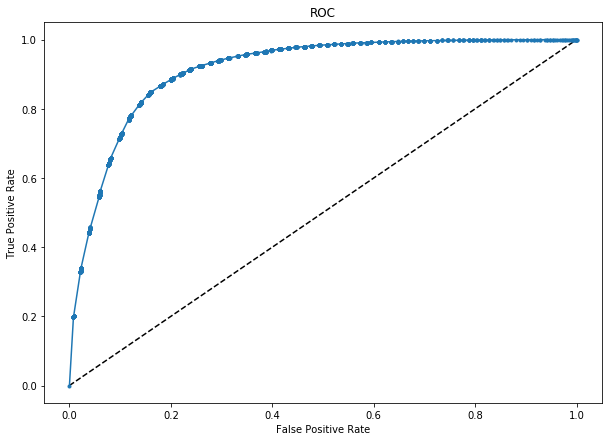

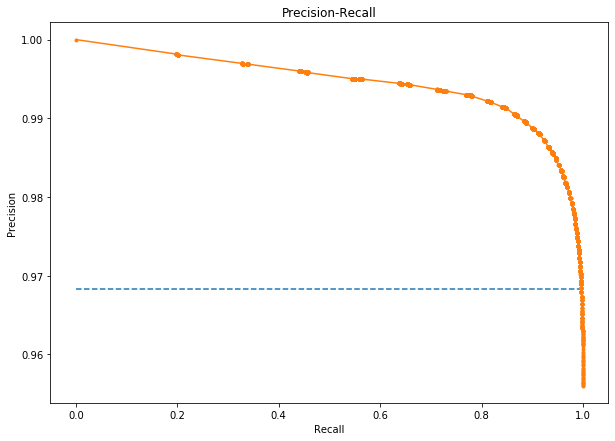

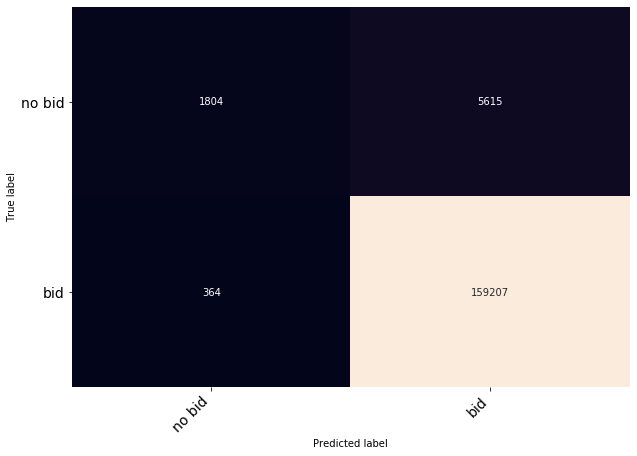

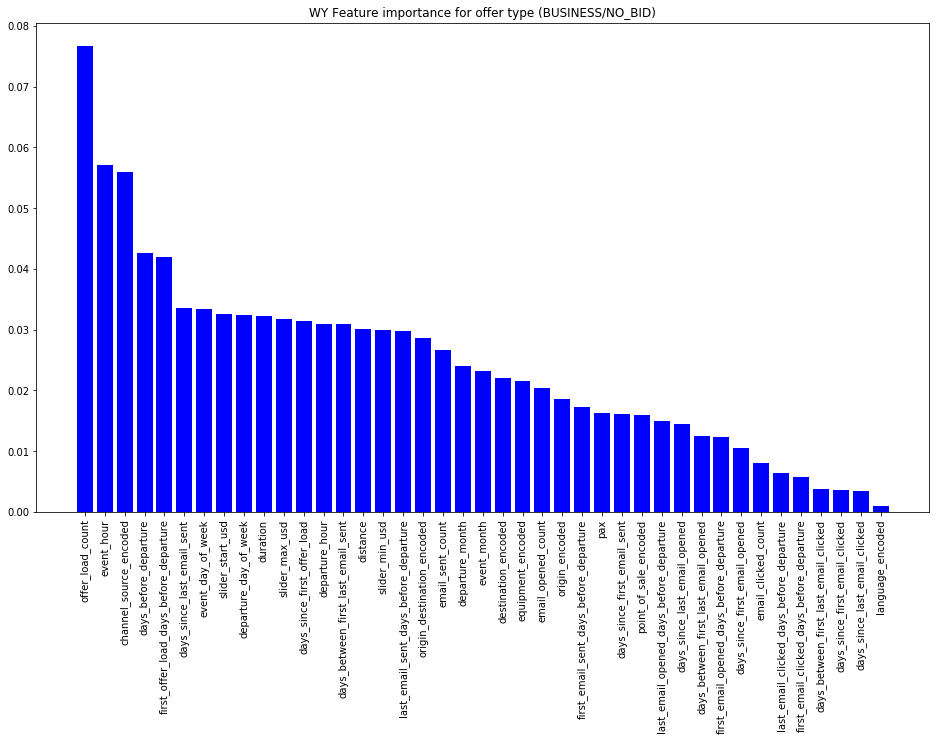

In [73]:
# run with a lot of data
train_and_evaluate(df,plot_learning_curves=False,limit=None, split_on_time=True)